In [1]:
spark

In [22]:
df = sqlContext.read.csv('../data/avazu/1M.csv', header=True, inferSchema=True)

In [23]:
catCols = ['C1'] + [f'C{k}' for k in range(14, 22)]
catCols += ['banner_pos', 'site_category', 'device_type', 'device_conn_type',
            'site_id', 'site_domain', 'app_id', 'app_domain', 'app_category', 'device_model']
df.select(catCols).show()

+----+-----+---+---+----+---+----+------+---+----------+-------------+-----------+----------------+--------+-----------+--------+----------+------------+------------+
|  C1|  C14|C15|C16| C17|C18| C19|   C20|C21|banner_pos|site_category|device_type|device_conn_type| site_id|site_domain|  app_id|app_domain|app_category|device_model|
+----+-----+---+---+----+---+----+------+---+----------+-------------+-----------+----------------+--------+-----------+--------+----------+------------+------------+
|1005|15699|320| 50|1722|  0|  35|    -1| 79|         0|     28905ebd|          1|               0|1fbe01fe|   f3845767|ecad2386|  7801e8d9|    07d7df22|    c6263d8a|
|1005|19733|320| 50|2260|  0| 171|100156| 91|         0|     50e219e0|          1|               0|85f751fd|   c4e18dd6|3f2a6cbb|  33da2e74|    cef3e649|    03683bd4|
|1005|15703|320| 50|1722|  0|  35|    -1| 79|         0|     28905ebd|          1|               0|1fbe01fe|   f3845767|ecad2386|  7801e8d9|    07d7df22|    76dc4769

In [24]:
from pyspark.sql.functions import udf

In [25]:
posMapper = udf(lambda x: 0 if x < 0 else x)
df = df.withColumn('C20_1', posMapper(df['C20']))

In [26]:
catCols.remove('C20')
catCols.append('C20_1')

In [27]:
from pyspark.ml.feature import OneHotEncoderEstimator

In [28]:
from pyspark.ml.feature import StringIndexer
for c in ['site_category', 'site_id', 'site_domain', 'app_id', 'app_domain', 'app_category', 'device_model']:
    si = StringIndexer(inputCol=c, outputCol=f'{c}_ix')
    df = si.fit(df).transform(df)
    catCols.remove(c)
    catCols.append(f'{c}_ix')

In [29]:
from pyspark.sql.types import IntegerType
df = df.withColumn("C20_1int", df['C20_1'].cast(IntegerType()))
catCols.remove('C20_1')
catCols.append('C20_1int')

In [30]:
encoder = OneHotEncoderEstimator(inputCols=catCols, outputCols=[c + 'Enc' for c in catCols])
enc_model = encoder.fit(df)
encoded = enc_model.transform(df)

In [31]:
trainCols = [c for c in encoded.columns if c.endswith('Enc')] + ['day', 'hour', 'dayofweek']

In [32]:
encoded = encoded.withColumn('label', encoded['click'].cast(IntegerType()))

In [33]:
from pyspark.ml.classification import LogisticRegression

In [34]:
from pyspark.ml.feature import VectorAssembler

In [35]:
va = VectorAssembler(inputCols=trainCols, outputCol='features')
encoded = va.transform(encoded)

In [36]:
lr = LogisticRegression(featuresCol='features', labelCol='label')

In [37]:
model = lr.fit(encoded)

In [38]:
result = model.evaluate(encoded)

In [39]:
result.accuracy

0.837024837024837

In [40]:
result.areaUnderROC

0.76182744964116

In [41]:
encoded.agg({'label': 'mean'}).collect()

[Row(avg(label)=0.1698051698051698)]

In [42]:
1 - 0.16980

0.8302

In [43]:
result.precisionByLabel

[0.8428764210312105, 0.6263598016724635]

In [32]:
result

In [44]:
result.recallByLabel

[0.9878365779564776, 0.0996908218250346]

In [45]:
roc = result.roc.toPandas()

In [46]:
roc.head()

,FPR,TPR
0,0.000000,0.000000
1,0.002581,0.038432
2,0.006462,0.066859
3,0.010800,0.093089
4,0.015669,0.115998


In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

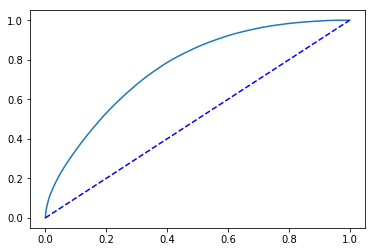

In [49]:
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0, 1], [0, 1], 'b--')